In [1]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import numpy as np

from mrcnn.utils import compute_ap, compute_recall
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from trainSocket import SocketDataset

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
CLASS_NAMES = ['BG','AOP_BTV1','AOP_DIO_01','AOP_EVK80',
                'AOP_TRAS1000','AOP_TRAS1000_no_key',
                'AOP_X10DER_KT_01', 'SPLITTER_MCP_03',
                'SPLITTER_POA_01IEC','SPLITTER_POA_01_met_kapje',
                'SPLITTER_POA_01_zonder_kapje', 'SPLITTER_POA_3_met_kapje',
                'SPLITTER_POA_3_zonder_kapje', 'SPLITTER_SQ601_met_kapje',
                'SPLITTER_UMU_met_kapje', 'WCD_tweegats']

In [3]:
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(CLASS_NAMES)

In [4]:
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="/Users/wolfsinem/maskrcnn/multiClassWeights/mask_rcnn_socketconfig_0001.h5", 
                   by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [5]:
image = cv2.imread("/Users/wolfsinem/Downloads/socketdata/Images/01370.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
r = model.detect([image], verbose=0)
r = r[0]

In [7]:
a = CLASS_NAMES[r['class_ids'][0]]

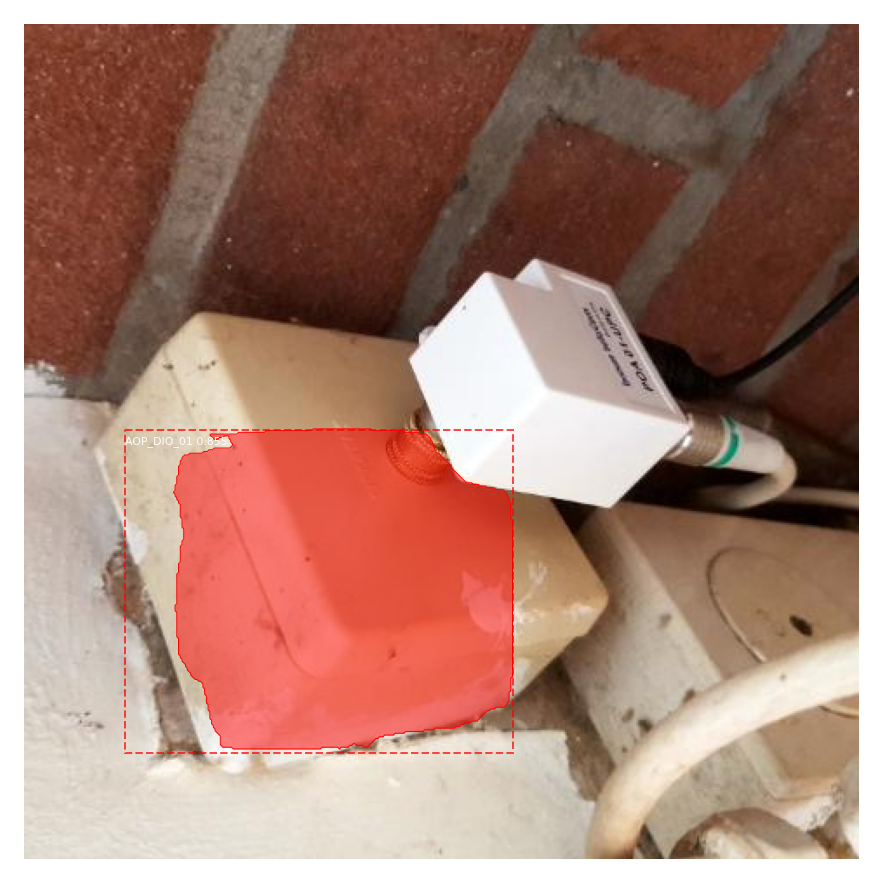

In [8]:
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

In [9]:
print("Predicted socket type {} with score {}".format(a, r['scores'][0]))

Predicted socket type AOP_DIO_01 with score 0.8548764586448669


In [10]:
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(CLASS_NAMES)

In [11]:
dataset_dir = '/Users/wolfsinem/Downloads/socketdata/'

test_set = SocketDataset()
test_set.load_dataset(dataset_dir=dataset_dir, is_train=False)
test_set.prepare()

In [12]:
class EvalImage():
  def __init__(self,dataset,model,cfg):
    self.dataset = dataset
    self.model   = model
    self.cfg     = cfg
 
  def evaluate_model(self , len=50):
    APs = list()
    precisions_dict = {}
    recall_dict     = {}
    for index,image_id in enumerate(self.dataset.image_ids):
      if(index > len):
         break; 
      image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(self.dataset, self.cfg,image_id, use_mini_mask=False)
    #   scaled_image = mold_image(image, self.cfg)
      sample = np.expand_dims(image, 0)
      yhat = self.model.detect(sample, verbose=1)
      r = yhat[0]
      AP, precisions, recalls, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
      precisions_dict[image_id] = np.mean(precisions)
      recall_dict[image_id] = np.mean(recalls)
      APs.append(AP)

    # mAP = np.mean(APs)
    return APs

In [13]:
config = SimpleConfig()
eval = EvalImage(test_set,model,config)

In [14]:
APs = eval.evaluate_model()

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000

In [18]:
mAP = np.mean(APs)
mAP

nan